# Customer Lifetime  Value (CLV) Prediction

In [298]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifetimes

from datetime import datetime
from dateutil.relativedelta import relativedelta

import os
from google.cloud import bigquery

### Import Data

In [8]:
# Import order data
gcr_project_id = os.getenv('GCR_CLV_PROJECT_ID')
QUERY  = f"""
WITH order_values AS (
    SELECT 
      order_id,
      SUM(sale_price) as order_value
    FROM `{gcr_project_id}.thelook_ecommerce.order_items`
    GROUP BY order_id
    ORDER BY order_id
)
SELECT 
  orders.order_id,
  orders.user_id,
  users.first_name,
  users.last_name,
  users.email,
  orders.created_at,
  orders.status,
  order_values.order_value
FROM `{gcr_project_id}.thelook_ecommerce.orders` AS orders
    LEFT JOIN `{gcr_project_id}.thelook_ecommerce.users` AS users ON orders.user_id = users.id
    LEFT JOIN order_values on orders.order_id = order_values.order_id
ORDER BY orders.order_id;
"""

client = bigquery.Client()

df = client.query_and_wait(QUERY).to_dataframe()

/Users/axel/ecommerce-project/env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


### Formatting Data - Calculate Frequency, Recency, Customer Age, and Customer Monetary Value.

In [9]:
# Reformat 'created_at' column the exclude time of day
from datetime import datetime
df2 = df.copy()
df2['created_at'] = df2.created_at.apply(lambda x : x.date())
df2.head()

,order_id,user_id,first_name,last_name,email,created_at,status,order_value
0,1,1,Kimberly,Long,kimberlylong@example.org,2022-04-04,Shipped,36.00
1,2,3,Gina,Jennings,ginajennings@example.com,2024-11-06,Processing,49.98
2,3,3,Gina,Jennings,ginajennings@example.com,2024-11-30,Shipped,40.58
3,4,4,Caitlyn,Zuniga,caitlynzuniga@example.com,2022-03-11,Cancelled,8.97
4,5,5,Tonya,Esparza,tonyaesparza@example.org,2021-09-10,Shipped,88.00


In [10]:
# Get Customer Summary Data : Frequency, Recency, Monetary Value
df_summary  = lifetimes.utils.summary_data_from_transaction_data(df2, 'user_id', 'created_at',
                                                                 freq='D', include_first_transaction = False)
df_summary['monetary_value'] = df2.groupby('user_id')[['order_value']].mean()
df_summary.head()

,frequency,recency,T,monetary_value
user_id,,,,
1,0.0,0.0,987.0,36.00
3,1.0,24.0,40.0,45.28
4,0.0,0.0,1011.0,8.97
5,0.0,0.0,1193.0,88.00
6,0.0,0.0,239.0,274.99


### Create CLV Prediction Model

In [23]:
# Check Gamma-Gamma model assumption - is there relationship between monetary value & frequency?
df_summary[['monetary_value', 'frequency']].corr()  # corr  = 0.00339
df_summary[df_summary.frequency != 0][['monetary_value', 'frequency']].corr()  # corr  = -0.004876

,monetary_value,frequency
monetary_value,1.000000,-0.004876
frequency,-0.004876,1.000000


In [27]:
# Create model to predict number of transactions that a customer will make in the future
bgf = lifetimes.BetaGeoFitter(0.01)
bgf.fit(df_summary['frequency'], df_summary['recency'], df_summary['T'])

<lifetimes.BetaGeoFitter: fitted with 79862 subjects, a: 0.13, alpha: 412.50, b: 0.34, r: 0.57>

In [57]:
len(bgf.data)

79862

In [24]:
# Create model to predict monetary value of individual orders
ggf = lifetimes.GammaGammaFitter()
ggf.fit(df_summary[df_summary.frequency != 0]['frequency'],
        df_summary[df_summary.frequency != 0]['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 29326 subjects, p: 3.66, q: 6.02, v: 119.20>


In [29]:
# Predict customers' conditional, expected average lifetime value
df_pred = ggf.conditional_expected_average_profit(df_summary['frequency'],
                                                  df_summary['monetary_value'])
df_pred.head()

print(f"The expected average profit per transaction of our customers, conditional on ..., is:\n{float(df_pred.mean()):.3f}")
print()
print(f"The true average profit per transaction of our customers is :\n{float(df_summary[df_summary.frequency != 0]['monetary_value'].mean()):.3f}")

user_id
1    86.775222
3    69.293596
4    86.775222
5    86.775222
6    86.775222
dtype: float64

In [43]:
# Predict customer lifetime value
ggf.customer_lifetime_value(
    bgf,
    df_summary['frequency'],
    df_summary['recency'],
    df_summary['T'],
    df_summary['monetary_value'],
    time=12,
    discount_rate=0.1,
    freq="D"
).to_frame()

,clv
user_id,
1,6.952203
3,32.586180
4,6.839315
5,6.089765
6,14.369053
...,...
99996,25.444638
99997,13.295230
99998,14.706858


### Define Prediction Model Classes

In [111]:
class PredictorGGF:
    def __init__(self, df_summary):
        self.df_summary = df_summary

    def check_correlation(self):
        repeating_customer_correlation = self.df_summary[self.df_summary.frequency != 0][['monetary_value', 'frequency']].corr().values[0,1]

        return float(repeating_customer_correlation)

    def fit_bgf(self, penalty_coef : float=0.01):

        self.bgf = lifetimes.BetaGeoFitter(penalty_coef)
        self.bgf.fit(self.df_summary['frequency'],
                    self.df_summary['recency'],
                    self.df_summary['T'])

        print(f"Beta-Gamma model successfully fitted :")
        print(self.bgf)

        return self.bgf.summary

    def fit_ggf(self, penalty_coef : float=0.01):

        correlation = self.check_correlation()
        assert correlation < 0.1, f"Correlation between frequency and monetary value for returning customers is {correlation} - this is quite high and may cause poor predictions"

        self.ggf = lifetimes.GammaGammaFitter(penalty_coef)
        self.ggf.fit(self.df_summary[self.df_summary.frequency != 0]['frequency'],
                     self.df_summary[self.df_summary.frequency != 0]['monetary_value'])

        print(f"Gamma-Gamma model successfully fitted :")
        print(self.ggf) 

        #assert float(ggf.params_['q']) > 1, "Outliers in the data are causing the 'q' parameter for the Gamma-Gamma model to be < 1 therefore model predictions will fail - Fix this by either removing outliers until you get 'q' > 1, or use raw monetary values to model CLV."

        return self.ggf.summary
    
    def predict_clv(self, time : int=12, discount_rate : float=0.1, freq : str="D"):

        # Predict customer lifetime value
        clv_preds_df = self.ggf.customer_lifetime_value(
                            self.bgf,
                            self.df_summary['frequency'],
                            self.df_summary['recency'],
                            self.df_summary['T'],
                            self.df_summary['monetary_value'],
                            time=time,
                            discount_rate=discount_rate,
                            freq=freq
                        ).to_frame()
        
        return clv_preds_df

In [113]:
class PredictorRawMonetaryCLV:
    def __init__(self, df_summary):
        self.df_summary = df_summary

    def fit_bgf(self, penalty_coef : float=0.01):

        bgf = lifetimes.BetaGeoFitter(penalty_coef)
        bgf.fit(self.df_summary['frequency'],
                self.df_summary['recency'],
                self.df_summary['T'])
        
        self.bgf = bgf
        print(f"Beta-Gamma model successfully fitted :")
        print(bgf)

        return bgf.summary

    def predict_clv(self, time : int=12, discount_rate : float=0.1, freq : str="D"):

        # Predict customer lifetime value
        clv_preds_df = lifetimes.utils._customer_lifetime_value(
                            self.bgf,
                            self.df_summary['frequency'],
                            self.df_summary['recency'],
                            self.df_summary['T'],
                            self.df_summary['monetary_value'],
                            time=time,
                            discount_rate=discount_rate,
                            freq=freq
                        ).to_frame()
        
        return clv_preds_df


### Utility functions for predicting CLV

In [257]:
def equity(row, bgf, discount_rate : float=0.1):

    rest=row['rest'].item()

    equity_pred = lifetimes.utils._customer_lifetime_value(
        bgf,
        row['frequency'],
        row['recency'],
        row['T'],
        row['monetary_value'],
        time=rest,
        discount_rate=discount_rate,
        freq='D')

    return equity_pred

In [259]:
def future_purchases(row, bgf):
    pred = bgf.conditional_expected_number_of_purchases_up_to_time(row['rest'],
                                                                   row['frequency'],
                                                                   row['recency'],
                                                                   row['T'])
    return pred

In [316]:
def get_summary_df(df : pd.DataFrame, 
                   train_period_start : datetime.date,
                   train_period_end : datetime.date,
                   test_period_end : datetime.date):
                      
    # Create copy of dataset & reformat 'created_at' column
    df1 = df.copy()
    df1['created_at'] = df1.created_at.apply(lambda x : x.date())

    # Filter out users that had transactions before the start of training period - i.e. who were 'alive' before training period
    first_order_dates = df1.groupby('user_id')['created_at'].min()    # Find the first order date for each user
    valid_users = first_order_dates[first_order_dates >= train_period_start].index    # Identify users whose first order occurred on or after the cutoff date

    # Filter the original DataFrame to include only valid users
    df1 = df1[df1['user_id'].isin(valid_users)]

    df_train = df1[(df1.created_at <= train_period_end)]
    df_test = df1[(df1.created_at > train_period_end) & (df1.created_at <= test_period_end)]

    # Get summary data from training data
    df_train_summary  = lifetimes.utils.summary_data_from_transaction_data(df_train, 'user_id', 'created_at',
                                                                           freq='D', include_first_transaction = False)
    df_train_summary = pd.merge(df_train_summary, df_train.groupby('user_id')['order_value'].agg(['mean', 'sum']), 
                                how='left', on='user_id').rename(columns={'mean' : 'monetary_value', 'sum' : 'revenue'})
    
    # Get test period summary data - identify true values for: i) amount the customer spent in remaining experiment period time, ii) customer CLV during experiment period
    df_test_summary = lifetimes.utils.summary_data_from_transaction_data(df_test, 'user_id', 'created_at',
                                                                         freq='D', include_first_transaction = True)

    df_test_summary = pd.merge(df_test_summary, df_test.groupby('user_id')['order_value'].agg('sum'), 
                            how='left', on='user_id').rename(columns={'frequency' : 'true_purchases', 'order_value':'true_equity'})
    
    return df_train_summary, df_test_summary

In [317]:
def pred_equity(predictor,
                df_train_summary : pd.DataFrame,
                train_period_start : datetime.date,
                test_period_end : datetime.date):
    
    # Calculate remaining time in experiment period for each customer
    experiment_period = round((test_period_end - train_period_start).days / 30.5)
    df_train_summary['rest'] = experiment_period - df_train_summary['T']/30.5

    # Predict amount the customer will spend in the remaining experiment period time
    df_train_summary['pred_equity'] = 0
    for i, row in df_train_summary.iterrows():
        df_train_summary.at[i, 'pred_equity'] = equity(row.to_frame().T, predictor.bgf).values[0]

    # Calculate predicted customer CLV during experiment period
    df_train_summary['pred_clv'] = df_train_summary['revenue'] + df_train_summary['pred_equity']
    df_train_summary['pred_purchases'] = df_train_summary.apply(lambda row: future_purchases(row, predictor.bgf)+row['frequency']+1, axis=1)

    return df_train_summary

In [318]:
def get_preds_summary(df_train_summary, df_test_summary):

    # Create dataframe to compare predictions vs true values
    df_preds_summary = pd.merge(df_train_summary, df_test_summary, how='left', on='user_id').drop(columns=['recency_y', 'T_y'])

    return df_preds_summary.fillna(0)

### Define utility functions for calculating error of predictions

In [324]:
def get_pred_errors(df_preds_summary):

    df_preds_summary['pred_equity_error'] = df_preds_summary['pred_equity'] - df_preds_summary['true_equity']
    df_preds_summary['pred_purchases_error'] = df_preds_summary['pred_purchases'] - df_preds_summary['true_purchases']

    return df_preds_summary

### Model Creation/Experimentation

In [ ]:
# Define model parameters to test
penalty_coef_vals = np.arange(0, 0.3, 0.01)

# Define Predictor

In [319]:
# Get training & testing summary data
df_train_summary, df_test_summary = get_summary_df(df, 
                                                   train_period_start=datetime(2022,12,31).date(),
                                                   train_period_end=datetime(2023,12,31).date(),
                                                   test_period_end=datetime.now().date())

In [320]:
# Define predictor
penalty_coef = 0.01
predictor = PredictorRawMonetaryCLV(df_train_summary)
predictor.fit_bgf(penalty_coef)

df_train_summary = pred_equity(predictor, df_train_summary,
                               train_period_start=datetime(2022,12,31).date(),
                               test_period_end=datetime.now().date())

df_preds_summary = get_preds_summary(df_train_summary, df_test_summary)
df_preds_summary.head()

Beta-Gamma model successfully fitted :
<lifetimes.BetaGeoFitter: fitted with 18820 subjects, a: 0.18, alpha: 207.80, b: 0.14, r: 0.29>


,frequency,revenue,rest,pred_equity,pred_clv,pred_purchases,true_purchases,true_equity
user_id,,,,,,,,
11,0.0,14.950000,20.590164,2.711109,17.661109,1.018898,NaN,NaN
16,0.0,77.990002,22.852459,17.599469,95.589471,1.026680,1.0,39.000000
17,0.0,224.980000,22.032787,46.960902,271.940901,1.023415,1.0,68.000000
29,0.0,14.000000,15.573770,1.692523,15.692523,1.009697,NaN,NaN
31,0.0,260.740005,21.540984,51.659112,312.399118,1.021723,1.0,139.990005


### Results Evaluation

In [325]:
# Get prediciton errors
df_preds_summary = get_pred_errors(df_preds_summary)
df_preds_summary.head()

,frequency,revenue,rest,pred_equity,pred_clv,pred_purchases,true_purchases,true_equity,pred_equity_error,pred_purchases_error
user_id,,,,,,,,,,
11,0.0,14.950000,20.590164,2.711109,17.661109,1.018898,0.0,0.000000,2.711109,1.018898
16,0.0,77.990002,22.852459,17.599469,95.589471,1.026680,1.0,39.000000,-21.400531,0.026680
17,0.0,224.980000,22.032787,46.960902,271.940901,1.023415,1.0,68.000000,-21.039098,0.023415
29,0.0,14.000000,15.573770,1.692523,15.692523,1.009697,0.0,0.000000,1.692523,1.009697
31,0.0,260.740005,21.540984,51.659112,312.399118,1.021723,1.0,139.990005,-88.330893,0.021723


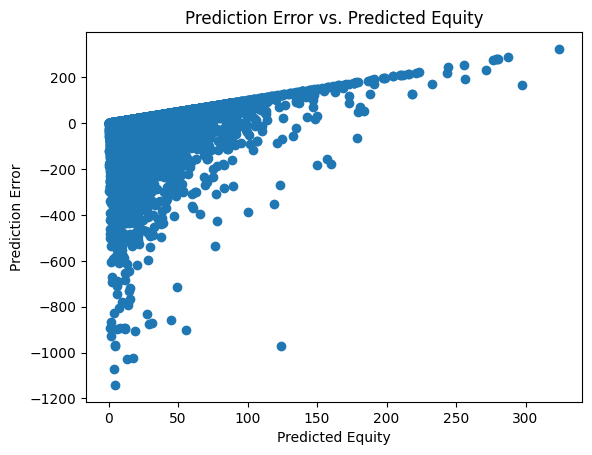

In [338]:
# Scatter plot of prediction error vs predicted equity - does our model make better predictions for customers w/
plt.scatter(df_preds_summary['pred_equity'], df_preds_summary['pred_equity_error'])
plt.title('Prediction Error vs. Predicted Equity')
plt.xlabel('Predicted Equity')
plt.ylabel('Prediction Error')

plt.show()

In [335]:
df_preds_summary[df_preds_summary.revenue < df_preds_summary.revenue.quantile(0.75)].sort_values(by='pred_clv')

,frequency,revenue,rest,pred_equity,pred_clv,pred_purchases,true_purchases,true_equity,pred_equity_error,pred_purchases_error
user_id,,,,,,,,,,
13277,0.0,0.020000,22.524590,0.004371,0.024371,1.025300,1.0,40.000000,-39.995629,0.025300
98035,0.0,0.490000,20.819672,0.090510,0.580510,1.019532,1.0,119.000000,-118.909490,0.019532
46660,0.0,1.510000,16.786885,0.199620,1.709620,1.011334,0.0,0.000000,0.199620,1.011334
10257,0.0,1.500000,19.868852,0.254500,1.754500,1.017072,0.0,0.000000,0.254500,1.017072
94356,0.0,1.820000,20.196721,0.320069,2.140069,1.017872,1.0,60.059999,-59.739931,0.017872
...,...,...,...,...,...,...,...,...,...,...
40375,2.0,116.980001,20.557377,56.939733,173.919734,3.128205,1.0,162.000000,-105.060267,2.128205
19597,3.0,131.000000,16.885246,46.781719,177.781719,4.107562,0.0,0.000000,46.781719,4.107562
51618,2.0,124.270002,19.770492,54.990019,179.260021,3.113119,1.0,14.990000,40.000019,2.113119
